## Softmax Function
- https://www.jianshu.com/p/cb93d5e39bca

In [2]:
import numpy as np
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))


y = np.array([0.8,0.5,0.7,0.6,0.9,1.5])

softmax_function(y)


array([0.15189927, 0.11252975, 0.13744415, 0.12436461, 0.16787466,
       0.30588757])

In [4]:
import numpy as np
def softmax_function_with_temperature(x, temperature):
    return np.exp(x/temperature) / np.sum(np.exp(x/temperature))

softmax_function_with_temperature(y,10)

array([0.16602326, 0.16111653, 0.1643713 , 0.16273578, 0.16769182,
       0.17806131])

In [5]:
softmax_function_with_temperature(y,0.5)

array([0.12027232, 0.06600685, 0.09847065, 0.08062095, 0.14690094,
       0.4877283 ])

## Time Series Analysis in Python
- https://www.kaggle.com/rakannimer/air-passenger-prediction
- https://github.com/ywchiu/cdc_course/blob/master/slides/20180724%20-%20R%20%E8%AA%9E%E8%A8%80%E8%88%87%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92(%E4%B8%83).pdf

## Normal Distribution

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


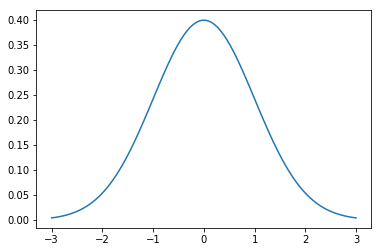

In [7]:
% pylab inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu       = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


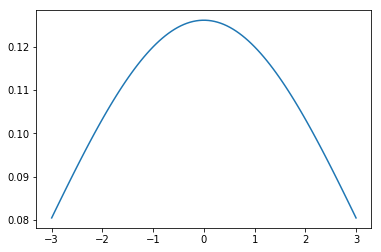

In [9]:
mu       = 0
variance = 10
sigma = math.sqrt(variance)
#x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x = np.linspace(mu - 3, mu + 3, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

## 使用VAE 生成圖片

### 引用套件

In [51]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from   scipy.stats import norm
import matplotlib.image as matimg
import glob

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives

### 設定網路參數

In [52]:
##math.sqrt(12288)

In [82]:
#num_training_examples = 1200
#num_testing_examples  = 125
num_training_examples = 171
num_testing_examples  = 32

#batch_size   = 25
batch_size   = 5
original_dim = 64 * 64 * 3 #this is same as image_vector_size
latent_dim   = 2
intermediate_dim = 256
epsilon_std  = 1.0

### 讀取圖片

In [83]:
def load_image(path):
    img = matimg.imread(path)
    return img

#following code loads data from local repo
#directory should have two subfolders, with name train and test
def load_local_data(path):
    paths = glob.glob(os.path.join(path + "/train", "*.jpg"))
    X_train = np.array( [ load_image(p) for p in paths ] )

    paths = glob.glob(os.path.join(path + "/test", "*.jpg"))
    X_test = np.array( [ load_image(p) for p in paths ] )
   
    return X_train, X_test

### 建立 Encoder

In [84]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean    = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

### 取樣函數

In [85]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### 建立解碼器

In [86]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h    = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded    = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### 計算 VAE 損失

#### KL Divergence
- https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%AF%B9%E7%86%B5

In [87]:
# modified calculation of loss
def vae_loss(x, x_decoded_mean):
    #xent_loss = reconstruction error
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

### 建立 VAE 模型

In [88]:

# vae model# vae mo 
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# if want to train with data from local repo
path="idol_face_vae"
(x_train, x_test) = load_local_data(path)
print(x_train.shape)

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



(171, 64, 64, 3)


In [89]:
x_train.shape

(171, 12288)

In [90]:
x_test.shape

(32, 12288)

In [91]:
#to train the model

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=50,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 171 samples, validate on 32 samples
Epoch 1/50
170/171 [============================>.] - ETA: 0s - loss: 9140.2746

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,256], In[1]: [5,2]
	 [[Node: training_3/RMSprop/gradients/dense_28/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_26/Relu, training_3/RMSprop/gradients/AddN_3)]]

### HDF5
- https://support.hdfgroup.org/HDF5/

In [34]:
vae.save_weights('vae_landscape_100.h5')

In [36]:
vae.load_weights('vae_landscape_100.h5')

### 產生生成器

In [37]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

# build a face generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded      = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### 圖片生成

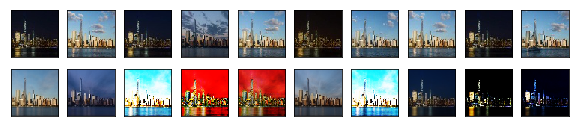

In [45]:
img_size = 64

# following values can generate some good skyline images
samples_encoded = [[5.55, -3.33], [-1.11, 10], [120, 13.3], [33.33, -77.77], [11.11, -33.33], [11.11, 11.11], [100, -33.33], [-7.77, -1.11], [-33.33, -11.11], [-33.33, 11.11]]
samples         = x_test[15:25]


# code to create a result.png with generated faces
plt.figure(figsize=(10, 2))

for i, yi in enumerate(samples_encoded):
    z_sample = np.array([[yi[0], yi[1]]])
    x_decoded = generator.predict(z_sample)
    x_decoded = x_decoded
    #print x_decoded.shape
    face = x_decoded[0].reshape(img_size, img_size, 3)


    ax1 = plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i].reshape(img_size, img_size, 3))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 10 + 1)
    plt.imshow(face)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



plt.savefig('result.png')
#plt.show()

## CelebA
- http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## RNN

In [93]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/2330.TW.csv')

In [94]:
df = df[~ df['Close'].isna()]

In [95]:
df.count()

Date         1851
Open         1851
High         1851
Low          1851
Close        1851
Adj Close    1851
Volume       1851
dtype: int64

In [96]:
trainset = df.iloc[0:1551,:]
testset  = df.iloc[1551: ,:]

In [97]:
training_set = trainset[~ trainset['Close'].isna()].iloc[:, 4:5].values

In [98]:
test_set = testset[~ testset['Close'].isna()].iloc[:, 4:5].values

In [101]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [102]:
import numpy as np
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [103]:
import numpy as np
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [104]:
# Importing the Keras libraries and packages
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [106]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
1491/1491 [==============================] - 5s 3ms/step - loss: 0.0066
Epoch 2/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0033
Epoch 3/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0031
Epoch 4/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 5/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0031
Epoch 6/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0028
Epoch 7/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0029
Epoch 8/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0028
Epoch 9/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0028
Epoch 10/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0024


In [110]:
real_stock_price = trainset.iloc[:,4:5].values

In [112]:
real_stock_price.shape

(1551, 1)

In [113]:
predicted_stock_price = regressor.predict(X_train)

In [115]:
predicted_stock_price.shape

(1491, 1)

In [116]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

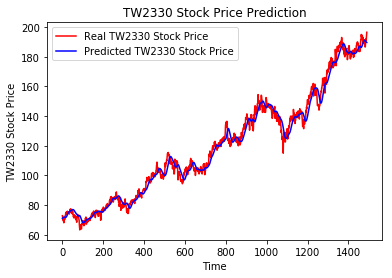

In [117]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price[60:], color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()

## GAN

- ! pip uninstall keras
- ! pip install keras==2.1.2


In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 10

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_encoder():
    # Encoder
    img = Input(shape=img_shape)
    h = Flatten()(img)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    mu = Dense(latent_dim)(h)
    log_var = Dense(latent_dim)(h)
    latent_repr = merge([mu, log_var],
            mode=lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2),
            output_shape=lambda p: p[0])

    return Model(img, latent_repr)

In [3]:
def build_decoder():

    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    z = Input(shape=(latent_dim,))
    img = model(z)

    return Model(z, img)

In [4]:
def build_discriminator():

    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    encoded_repr = Input(shape=(latent_dim, ))
    validity = model(encoded_repr)

    return Model(encoded_repr, validity)

In [5]:
def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake  = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        #  Train Discriminator

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #  Train Generator

        # Train the generator
        g_loss = adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

In [6]:
def sample_images(epoch):
    r, c = 5, 5

    z = np.random.normal(size=(r*c, latent_dim))
    gen_imgs = decoder.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [7]:
def save_model():

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(generator, "aae_generator")
    save(discriminator, "aae_discriminator")

In [8]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the encoder / decoder
encoder = build_encoder()
decoder = build_decoder()

img = Input(shape=img_shape)
# The generator takes the image, encodes it and reconstructs it
# from the encoding
encoded_repr = encoder(img)
reconstructed_img = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(img, [reconstructed_img, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999,0.001],optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdim

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [10]:
import os
os.mkdir('images')

In [11]:
train(epochs=2000, batch_size=32, sample_interval=200)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.729147, acc: 32.81%] [G loss: 0.949014, mse: 0.949221]
1 [D loss: 0.686598, acc: 48.44%] [G loss: 0.922717, mse: 0.922826]
2 [D loss: 0.626587, acc: 65.62%] [G loss: 0.902155, mse: 0.902093]
3 [D loss: 0.513028, acc: 73.44%] [G loss: 0.864788, mse: 0.864162]
4 [D loss: 0.410023, acc: 79.69%] [G loss: 0.785470, mse: 0.783750]
5 [D loss: 0.348339, acc: 82.81%] [G loss: 0.686448, mse: 0.683318]
6 [D loss: 0.302231, acc: 95.31%] [G loss: 0.580449, mse: 0.575662]
7 [D loss: 0.301508, acc: 87.50%] [G loss: 0.491636, mse: 0.485597]
8 [D loss: 0.294097, acc: 89.06%] [G loss: 0.405837, mse: 0.398747]
9 [D loss: 0.261811, acc: 92.19%] [G loss: 0.310409, mse: 0.302192]
10 [D loss: 0.237698, acc: 96.88%] [G loss: 0.296157, mse: 0.287537]
11 [D loss: 0.248660, acc: 95.31%] [G loss: 0.308740, mse: 0.300597]
12 [D loss: 0.221164, acc: 100.00%] [G loss: 0.275827, mse: 0.268026]
13 [D loss: 0.216699, acc: 96.88%] [G loss: 0.275080, mse: 0.268176]
14 [D loss: 0.175103, acc: 100.00%] [G loss

119 [D loss: 0.348978, acc: 85.94%] [G loss: 0.147822, mse: 0.142222]
120 [D loss: 0.279411, acc: 84.38%] [G loss: 0.126124, mse: 0.116553]
121 [D loss: 0.294847, acc: 84.38%] [G loss: 0.154836, mse: 0.148077]
122 [D loss: 0.357854, acc: 82.81%] [G loss: 0.144351, mse: 0.139573]
123 [D loss: 0.297301, acc: 84.38%] [G loss: 0.133287, mse: 0.126089]
124 [D loss: 0.296440, acc: 85.94%] [G loss: 0.127411, mse: 0.121906]
125 [D loss: 0.320339, acc: 82.81%] [G loss: 0.157243, mse: 0.152155]
126 [D loss: 0.251234, acc: 89.06%] [G loss: 0.122539, mse: 0.116097]
127 [D loss: 0.302876, acc: 82.81%] [G loss: 0.131191, mse: 0.126113]
128 [D loss: 0.253095, acc: 84.38%] [G loss: 0.140373, mse: 0.133874]
129 [D loss: 0.273426, acc: 87.50%] [G loss: 0.136674, mse: 0.132098]
130 [D loss: 0.260820, acc: 89.06%] [G loss: 0.140817, mse: 0.136344]
131 [D loss: 0.311503, acc: 81.25%] [G loss: 0.126396, mse: 0.121209]
132 [D loss: 0.413800, acc: 75.00%] [G loss: 0.137744, mse: 0.133202]
133 [D loss: 0.20972

241 [D loss: 0.051228, acc: 100.00%] [G loss: 0.135992, mse: 0.130767]
242 [D loss: 0.076441, acc: 100.00%] [G loss: 0.131783, mse: 0.126825]
243 [D loss: 0.068656, acc: 98.44%] [G loss: 0.127549, mse: 0.122062]
244 [D loss: 0.072258, acc: 100.00%] [G loss: 0.122039, mse: 0.116777]
245 [D loss: 0.057560, acc: 100.00%] [G loss: 0.121828, mse: 0.116582]
246 [D loss: 0.049755, acc: 100.00%] [G loss: 0.124444, mse: 0.118909]
247 [D loss: 0.074308, acc: 98.44%] [G loss: 0.138785, mse: 0.133740]
248 [D loss: 0.060190, acc: 100.00%] [G loss: 0.128205, mse: 0.122553]
249 [D loss: 0.052483, acc: 100.00%] [G loss: 0.109089, mse: 0.103184]
250 [D loss: 0.059144, acc: 100.00%] [G loss: 0.123848, mse: 0.118584]
251 [D loss: 0.056972, acc: 100.00%] [G loss: 0.120251, mse: 0.115041]
252 [D loss: 0.050480, acc: 100.00%] [G loss: 0.119921, mse: 0.114543]
253 [D loss: 0.082995, acc: 100.00%] [G loss: 0.144120, mse: 0.139127]
254 [D loss: 0.080549, acc: 98.44%] [G loss: 0.117455, mse: 0.112437]
255 [D lo

359 [D loss: 0.020148, acc: 100.00%] [G loss: 0.107004, mse: 0.100603]
360 [D loss: 0.018564, acc: 100.00%] [G loss: 0.117571, mse: 0.111285]
361 [D loss: 0.021329, acc: 100.00%] [G loss: 0.121835, mse: 0.115513]
362 [D loss: 0.023280, acc: 100.00%] [G loss: 0.107591, mse: 0.101350]
363 [D loss: 0.018753, acc: 100.00%] [G loss: 0.111404, mse: 0.105426]
364 [D loss: 0.018476, acc: 100.00%] [G loss: 0.127267, mse: 0.121287]
365 [D loss: 0.021150, acc: 100.00%] [G loss: 0.117577, mse: 0.111647]
366 [D loss: 0.022290, acc: 100.00%] [G loss: 0.117388, mse: 0.111233]
367 [D loss: 0.022935, acc: 100.00%] [G loss: 0.126822, mse: 0.121151]
368 [D loss: 0.018108, acc: 100.00%] [G loss: 0.114089, mse: 0.107827]
369 [D loss: 0.023819, acc: 100.00%] [G loss: 0.108539, mse: 0.101735]
370 [D loss: 0.015791, acc: 100.00%] [G loss: 0.109068, mse: 0.102796]
371 [D loss: 0.035952, acc: 98.44%] [G loss: 0.121418, mse: 0.115913]
372 [D loss: 0.027486, acc: 100.00%] [G loss: 0.119357, mse: 0.113281]
373 [D 

479 [D loss: 0.023276, acc: 100.00%] [G loss: 0.112912, mse: 0.106202]
480 [D loss: 0.016817, acc: 100.00%] [G loss: 0.103583, mse: 0.096439]
481 [D loss: 0.014989, acc: 100.00%] [G loss: 0.113699, mse: 0.106558]
482 [D loss: 0.013378, acc: 100.00%] [G loss: 0.115398, mse: 0.108006]
483 [D loss: 0.015837, acc: 100.00%] [G loss: 0.124083, mse: 0.118001]
484 [D loss: 0.016128, acc: 100.00%] [G loss: 0.116585, mse: 0.109801]
485 [D loss: 0.021727, acc: 100.00%] [G loss: 0.111104, mse: 0.104462]
486 [D loss: 0.021868, acc: 100.00%] [G loss: 0.121117, mse: 0.115198]
487 [D loss: 0.036559, acc: 98.44%] [G loss: 0.118190, mse: 0.111822]
488 [D loss: 0.015997, acc: 100.00%] [G loss: 0.109318, mse: 0.102833]
489 [D loss: 0.016975, acc: 100.00%] [G loss: 0.111525, mse: 0.104811]
490 [D loss: 0.017921, acc: 100.00%] [G loss: 0.108912, mse: 0.102144]
491 [D loss: 0.014741, acc: 100.00%] [G loss: 0.121625, mse: 0.114978]
492 [D loss: 0.025762, acc: 100.00%] [G loss: 0.108525, mse: 0.102023]
493 [D 

595 [D loss: 0.025017, acc: 100.00%] [G loss: 0.111327, mse: 0.104055]
596 [D loss: 0.014217, acc: 100.00%] [G loss: 0.103098, mse: 0.096015]
597 [D loss: 0.013700, acc: 100.00%] [G loss: 0.090456, mse: 0.083393]
598 [D loss: 0.032856, acc: 100.00%] [G loss: 0.117283, mse: 0.110479]
599 [D loss: 0.029911, acc: 98.44%] [G loss: 0.104672, mse: 0.097781]
600 [D loss: 0.017912, acc: 100.00%] [G loss: 0.110168, mse: 0.103670]
601 [D loss: 0.024829, acc: 100.00%] [G loss: 0.101226, mse: 0.094638]
602 [D loss: 0.012218, acc: 100.00%] [G loss: 0.106657, mse: 0.099408]
603 [D loss: 0.047244, acc: 98.44%] [G loss: 0.122864, mse: 0.116397]
604 [D loss: 0.013873, acc: 100.00%] [G loss: 0.105436, mse: 0.097666]
605 [D loss: 0.015032, acc: 100.00%] [G loss: 0.103538, mse: 0.096347]
606 [D loss: 0.046908, acc: 98.44%] [G loss: 0.106086, mse: 0.098781]
607 [D loss: 0.031444, acc: 98.44%] [G loss: 0.119962, mse: 0.113978]
608 [D loss: 0.024369, acc: 100.00%] [G loss: 0.108375, mse: 0.101845]
609 [D los

828 [D loss: 0.105312, acc: 93.75%] [G loss: 0.103531, mse: 0.097666]
829 [D loss: 0.055805, acc: 100.00%] [G loss: 0.084500, mse: 0.078370]
830 [D loss: 0.112178, acc: 96.88%] [G loss: 0.101003, mse: 0.095769]
831 [D loss: 0.099738, acc: 98.44%] [G loss: 0.109702, mse: 0.103158]
832 [D loss: 0.045304, acc: 100.00%] [G loss: 0.095444, mse: 0.088695]
833 [D loss: 0.114722, acc: 96.88%] [G loss: 0.091321, mse: 0.085802]
834 [D loss: 0.088184, acc: 96.88%] [G loss: 0.108285, mse: 0.102608]
835 [D loss: 0.043968, acc: 98.44%] [G loss: 0.113662, mse: 0.108154]
836 [D loss: 0.061973, acc: 98.44%] [G loss: 0.098540, mse: 0.092628]
837 [D loss: 0.053623, acc: 98.44%] [G loss: 0.085216, mse: 0.079465]
838 [D loss: 0.142368, acc: 93.75%] [G loss: 0.095241, mse: 0.088990]
839 [D loss: 0.054256, acc: 96.88%] [G loss: 0.114240, mse: 0.108609]
840 [D loss: 0.101527, acc: 95.31%] [G loss: 0.101061, mse: 0.094619]
841 [D loss: 0.086714, acc: 95.31%] [G loss: 0.093001, mse: 0.087101]
842 [D loss: 0.094

947 [D loss: 0.152271, acc: 92.19%] [G loss: 0.103450, mse: 0.098275]
948 [D loss: 0.086658, acc: 98.44%] [G loss: 0.098703, mse: 0.092643]
949 [D loss: 0.133904, acc: 93.75%] [G loss: 0.088023, mse: 0.082987]
950 [D loss: 0.178947, acc: 89.06%] [G loss: 0.111662, mse: 0.107231]
951 [D loss: 0.125166, acc: 95.31%] [G loss: 0.090279, mse: 0.085111]
952 [D loss: 0.191525, acc: 89.06%] [G loss: 0.097641, mse: 0.093302]
953 [D loss: 0.075086, acc: 98.44%] [G loss: 0.099247, mse: 0.094272]
954 [D loss: 0.188701, acc: 93.75%] [G loss: 0.101387, mse: 0.096258]
955 [D loss: 0.107971, acc: 95.31%] [G loss: 0.100405, mse: 0.094716]
956 [D loss: 0.130788, acc: 95.31%] [G loss: 0.101411, mse: 0.095992]
957 [D loss: 0.259718, acc: 87.50%] [G loss: 0.111737, mse: 0.107221]
958 [D loss: 0.163613, acc: 89.06%] [G loss: 0.088929, mse: 0.083820]
959 [D loss: 0.231353, acc: 89.06%] [G loss: 0.103577, mse: 0.098782]
960 [D loss: 0.127073, acc: 93.75%] [G loss: 0.107505, mse: 0.102860]
961 [D loss: 0.09843

1068 [D loss: 0.242512, acc: 87.50%] [G loss: 0.108407, mse: 0.104640]
1069 [D loss: 0.205933, acc: 89.06%] [G loss: 0.098465, mse: 0.094388]
1070 [D loss: 0.414500, acc: 84.38%] [G loss: 0.102196, mse: 0.098224]
1071 [D loss: 0.516723, acc: 81.25%] [G loss: 0.099629, mse: 0.095355]
1072 [D loss: 0.208070, acc: 92.19%] [G loss: 0.081167, mse: 0.076592]
1073 [D loss: 0.238870, acc: 92.19%] [G loss: 0.100507, mse: 0.095905]
1074 [D loss: 0.334184, acc: 89.06%] [G loss: 0.102368, mse: 0.097040]
1075 [D loss: 0.239198, acc: 87.50%] [G loss: 0.088449, mse: 0.083824]
1076 [D loss: 0.215120, acc: 90.62%] [G loss: 0.089091, mse: 0.084926]
1077 [D loss: 0.323384, acc: 85.94%] [G loss: 0.101942, mse: 0.097886]
1078 [D loss: 0.193185, acc: 90.62%] [G loss: 0.102453, mse: 0.097895]
1079 [D loss: 0.245942, acc: 89.06%] [G loss: 0.091995, mse: 0.087143]
1080 [D loss: 0.214939, acc: 90.62%] [G loss: 0.100413, mse: 0.096214]
1081 [D loss: 0.305287, acc: 85.94%] [G loss: 0.086622, mse: 0.082609]
1082 [

1190 [D loss: 0.249394, acc: 87.50%] [G loss: 0.078491, mse: 0.074187]
1191 [D loss: 0.336129, acc: 84.38%] [G loss: 0.079960, mse: 0.076215]
1192 [D loss: 0.300002, acc: 89.06%] [G loss: 0.091642, mse: 0.088452]
1193 [D loss: 0.395726, acc: 84.38%] [G loss: 0.081730, mse: 0.078781]
1194 [D loss: 0.174539, acc: 89.06%] [G loss: 0.088069, mse: 0.084157]
1195 [D loss: 0.317851, acc: 85.94%] [G loss: 0.094604, mse: 0.091291]
1196 [D loss: 0.444361, acc: 84.38%] [G loss: 0.087997, mse: 0.084668]
1197 [D loss: 0.301581, acc: 87.50%] [G loss: 0.089864, mse: 0.086554]
1198 [D loss: 0.204155, acc: 89.06%] [G loss: 0.088837, mse: 0.085657]
1199 [D loss: 0.230173, acc: 89.06%] [G loss: 0.092307, mse: 0.088584]
1200 [D loss: 0.277843, acc: 89.06%] [G loss: 0.101761, mse: 0.098612]
1201 [D loss: 0.269881, acc: 87.50%] [G loss: 0.102634, mse: 0.098913]
1202 [D loss: 0.305569, acc: 89.06%] [G loss: 0.098281, mse: 0.094459]
1203 [D loss: 0.142341, acc: 95.31%] [G loss: 0.091884, mse: 0.088278]
1204 [

1308 [D loss: 0.321174, acc: 85.94%] [G loss: 0.083881, mse: 0.080738]
1309 [D loss: 0.398353, acc: 84.38%] [G loss: 0.092242, mse: 0.089997]
1310 [D loss: 0.303911, acc: 87.50%] [G loss: 0.080434, mse: 0.077171]
1311 [D loss: 0.222858, acc: 89.06%] [G loss: 0.083961, mse: 0.080953]
1312 [D loss: 0.341130, acc: 84.38%] [G loss: 0.096036, mse: 0.093385]
1313 [D loss: 0.283138, acc: 85.94%] [G loss: 0.085764, mse: 0.082517]
1314 [D loss: 0.345983, acc: 89.06%] [G loss: 0.100634, mse: 0.097896]
1315 [D loss: 0.435032, acc: 79.69%] [G loss: 0.099799, mse: 0.097446]
1316 [D loss: 0.316244, acc: 90.62%] [G loss: 0.081639, mse: 0.078657]
1317 [D loss: 0.292295, acc: 85.94%] [G loss: 0.093851, mse: 0.090715]
1318 [D loss: 0.293630, acc: 87.50%] [G loss: 0.095410, mse: 0.092648]
1319 [D loss: 0.356197, acc: 87.50%] [G loss: 0.084461, mse: 0.081873]
1320 [D loss: 0.358680, acc: 82.81%] [G loss: 0.095251, mse: 0.092052]
1321 [D loss: 0.334469, acc: 85.94%] [G loss: 0.081792, mse: 0.078753]
1322 [

1428 [D loss: 0.247346, acc: 92.19%] [G loss: 0.095748, mse: 0.092492]
1429 [D loss: 0.291681, acc: 90.62%] [G loss: 0.099761, mse: 0.097088]
1430 [D loss: 0.302244, acc: 82.81%] [G loss: 0.087615, mse: 0.084837]
1431 [D loss: 0.298064, acc: 82.81%] [G loss: 0.097063, mse: 0.094545]
1432 [D loss: 0.263038, acc: 90.62%] [G loss: 0.091919, mse: 0.089054]
1433 [D loss: 0.272322, acc: 85.94%] [G loss: 0.093642, mse: 0.090576]
1434 [D loss: 0.445617, acc: 79.69%] [G loss: 0.097918, mse: 0.095434]
1435 [D loss: 0.464890, acc: 78.12%] [G loss: 0.091725, mse: 0.089460]
1436 [D loss: 0.333886, acc: 84.38%] [G loss: 0.097216, mse: 0.094335]
1437 [D loss: 0.379875, acc: 85.94%] [G loss: 0.090268, mse: 0.087480]
1438 [D loss: 0.423068, acc: 84.38%] [G loss: 0.096426, mse: 0.094071]
1439 [D loss: 0.244558, acc: 87.50%] [G loss: 0.097064, mse: 0.093535]
1440 [D loss: 0.416907, acc: 85.94%] [G loss: 0.097235, mse: 0.094405]
1441 [D loss: 0.304354, acc: 89.06%] [G loss: 0.089064, mse: 0.086126]
1442 [

1545 [D loss: 0.468557, acc: 75.00%] [G loss: 0.086835, mse: 0.084228]
1546 [D loss: 0.336113, acc: 84.38%] [G loss: 0.087939, mse: 0.084976]
1547 [D loss: 0.358005, acc: 84.38%] [G loss: 0.092540, mse: 0.089386]
1548 [D loss: 0.326133, acc: 84.38%] [G loss: 0.086451, mse: 0.084010]
1549 [D loss: 0.227461, acc: 90.62%] [G loss: 0.088281, mse: 0.085603]
1550 [D loss: 0.545725, acc: 71.88%] [G loss: 0.082759, mse: 0.080541]
1551 [D loss: 0.254595, acc: 89.06%] [G loss: 0.083587, mse: 0.080687]
1552 [D loss: 0.312383, acc: 85.94%] [G loss: 0.078232, mse: 0.075759]
1553 [D loss: 0.285917, acc: 85.94%] [G loss: 0.083398, mse: 0.081328]
1554 [D loss: 0.369700, acc: 79.69%] [G loss: 0.090094, mse: 0.087848]
1555 [D loss: 0.356171, acc: 84.38%] [G loss: 0.086567, mse: 0.083858]
1556 [D loss: 0.317631, acc: 85.94%] [G loss: 0.106819, mse: 0.104248]
1557 [D loss: 0.342684, acc: 85.94%] [G loss: 0.086752, mse: 0.084166]
1558 [D loss: 0.288464, acc: 89.06%] [G loss: 0.078827, mse: 0.076288]
1559 [

1662 [D loss: 0.318268, acc: 84.38%] [G loss: 0.082978, mse: 0.080875]
1663 [D loss: 0.303272, acc: 85.94%] [G loss: 0.069783, mse: 0.067112]
1664 [D loss: 0.364246, acc: 87.50%] [G loss: 0.075826, mse: 0.073434]
1665 [D loss: 0.410533, acc: 82.81%] [G loss: 0.096671, mse: 0.094550]
1666 [D loss: 0.365726, acc: 85.94%] [G loss: 0.086668, mse: 0.084228]
1667 [D loss: 0.284385, acc: 92.19%] [G loss: 0.083394, mse: 0.081174]
1668 [D loss: 0.391797, acc: 79.69%] [G loss: 0.100861, mse: 0.098804]
1669 [D loss: 0.588355, acc: 73.44%] [G loss: 0.094535, mse: 0.092355]
1670 [D loss: 0.455872, acc: 82.81%] [G loss: 0.085668, mse: 0.083656]
1671 [D loss: 0.339565, acc: 85.94%] [G loss: 0.091363, mse: 0.089540]
1672 [D loss: 0.321452, acc: 87.50%] [G loss: 0.076081, mse: 0.073538]
1673 [D loss: 0.400711, acc: 84.38%] [G loss: 0.098261, mse: 0.095768]
1674 [D loss: 0.515406, acc: 76.56%] [G loss: 0.091249, mse: 0.089061]
1675 [D loss: 0.386869, acc: 82.81%] [G loss: 0.089507, mse: 0.087615]
1676 [

1779 [D loss: 0.250160, acc: 89.06%] [G loss: 0.094077, mse: 0.091620]
1780 [D loss: 0.290297, acc: 89.06%] [G loss: 0.092273, mse: 0.089760]
1781 [D loss: 0.495081, acc: 79.69%] [G loss: 0.094383, mse: 0.092265]
1782 [D loss: 0.449764, acc: 76.56%] [G loss: 0.096943, mse: 0.095010]
1783 [D loss: 0.566268, acc: 64.06%] [G loss: 0.095655, mse: 0.094254]
1784 [D loss: 0.419709, acc: 87.50%] [G loss: 0.084546, mse: 0.082308]
1785 [D loss: 0.424788, acc: 76.56%] [G loss: 0.094623, mse: 0.092176]
1786 [D loss: 0.447288, acc: 79.69%] [G loss: 0.098520, mse: 0.096695]
1787 [D loss: 0.521468, acc: 84.38%] [G loss: 0.084672, mse: 0.082470]
1788 [D loss: 0.384394, acc: 87.50%] [G loss: 0.095046, mse: 0.093082]
1789 [D loss: 0.514421, acc: 78.12%] [G loss: 0.098476, mse: 0.096626]
1790 [D loss: 0.380958, acc: 81.25%] [G loss: 0.091741, mse: 0.089519]
1791 [D loss: 0.710998, acc: 68.75%] [G loss: 0.097150, mse: 0.095090]
1792 [D loss: 0.420942, acc: 84.38%] [G loss: 0.091578, mse: 0.089655]
1793 [

1899 [D loss: 0.383678, acc: 82.81%] [G loss: 0.089085, mse: 0.086264]
1900 [D loss: 0.373639, acc: 85.94%] [G loss: 0.086851, mse: 0.084788]
1901 [D loss: 0.370263, acc: 84.38%] [G loss: 0.091287, mse: 0.089183]
1902 [D loss: 0.387082, acc: 82.81%] [G loss: 0.080662, mse: 0.078941]
1903 [D loss: 0.727346, acc: 71.88%] [G loss: 0.079740, mse: 0.078219]
1904 [D loss: 0.333967, acc: 89.06%] [G loss: 0.078494, mse: 0.076444]
1905 [D loss: 0.455094, acc: 79.69%] [G loss: 0.083187, mse: 0.081484]
1906 [D loss: 0.361054, acc: 84.38%] [G loss: 0.073909, mse: 0.071846]
1907 [D loss: 0.394855, acc: 78.12%] [G loss: 0.092528, mse: 0.090633]
1908 [D loss: 0.420864, acc: 81.25%] [G loss: 0.082638, mse: 0.081078]
1909 [D loss: 0.407780, acc: 82.81%] [G loss: 0.088981, mse: 0.086539]
1910 [D loss: 0.337596, acc: 85.94%] [G loss: 0.083453, mse: 0.081263]
1911 [D loss: 0.309051, acc: 89.06%] [G loss: 0.065382, mse: 0.063315]
1912 [D loss: 0.585805, acc: 76.56%] [G loss: 0.097528, mse: 0.096240]
1913 [

In [14]:
import os
os.listdir('images')

['mnist_0.png',
 'mnist_1000.png',
 'mnist_1200.png',
 'mnist_1400.png',
 'mnist_1600.png',
 'mnist_1800.png',
 'mnist_200.png',
 'mnist_400.png',
 'mnist_600.png',
 'mnist_800.png']

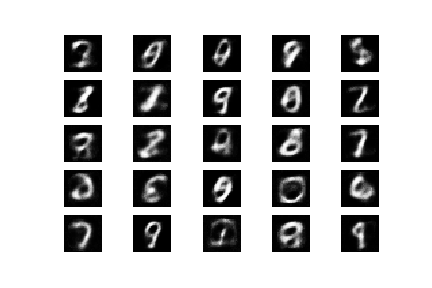

In [20]:
from PIL import Image
Image.open('images/mnist_1800.png')